## Deep learning with Keras: Chest accelerometer data

Dataset from https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+from+Single+Chest-Mounted+Accelerometer

In [1]:
# Set a seed for reproducibility
import numpy as np
seed = 42
np.random.seed(seed)

In [ ]:
import keras

In [63]:
iris = np.load("data/iris_data.npy")
iris_labels = np.load("data/iris_labels.npy")

In [71]:
iris

array([[ 5.1,  3.5,  1.4,  0.2],
       [ 4.9,  3. ,  1.4,  0.2],
       [ 4.7,  3.2,  1.3,  0.2],
       [ 4.6,  3.1,  1.5,  0.2],
       [ 5. ,  3.6,  1.4,  0.2],
       [ 5.4,  3.9,  1.7,  0.4],
       [ 4.6,  3.4,  1.4,  0.3],
       [ 5. ,  3.4,  1.5,  0.2],
       [ 4.4,  2.9,  1.4,  0.2],
       [ 4.9,  3.1,  1.5,  0.1],
       [ 5.4,  3.7,  1.5,  0.2],
       [ 4.8,  3.4,  1.6,  0.2],
       [ 4.8,  3. ,  1.4,  0.1],
       [ 4.3,  3. ,  1.1,  0.1],
       [ 5.8,  4. ,  1.2,  0.2],
       [ 5.7,  4.4,  1.5,  0.4],
       [ 5.4,  3.9,  1.3,  0.4],
       [ 5.1,  3.5,  1.4,  0.3],
       [ 5.7,  3.8,  1.7,  0.3],
       [ 5.1,  3.8,  1.5,  0.3],
       [ 5.4,  3.4,  1.7,  0.2],
       [ 5.1,  3.7,  1.5,  0.4],
       [ 4.6,  3.6,  1. ,  0.2],
       [ 5.1,  3.3,  1.7,  0.5],
       [ 4.8,  3.4,  1.9,  0.2],
       [ 5. ,  3. ,  1.6,  0.2],
       [ 5. ,  3.4,  1.6,  0.4],
       [ 5.2,  3.5,  1.5,  0.2],
       [ 5.2,  3.4,  1.4,  0.2],
       [ 4.7,  3.2,  1.6,  0.2],
       [ 4

In [70]:
iris_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
from keras.utils import to_categorical

In [67]:
iris_onehot = to_categorical(iris_labels)
iris_onehot

In [73]:
from keras.models import Sequential
from keras.layers import Dense

In [112]:
model = Sequential()

model.add(Dense(10, activation="sigmoid", input_dim=4))
model.add(Dense(3, activation="softmax"))

In [113]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 10)                50        
_________________________________________________________________
dense_40 (Dense)             (None, 3)                 33        
Total params: 83
Trainable params: 83
Non-trainable params: 0
_________________________________________________________________


In [114]:
model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["acc"])

In [115]:
model.fit(iris, iris_onehot, epochs=100, batch_size=20, validation_split=0.2)

Train on 120 samples, validate on 30 samples
Epoch 1/100
120/120 [==============================] - 1s 10ms/step - loss: 1.0203 - acc: 0.4167 - val_loss: 1.2532 - val_acc: 0.0000e+00
Epoch 2/100
120/120 [==============================] - 0s 183us/step - loss: 1.0099 - acc: 0.4167 - val_loss: 1.2809 - val_acc: 0.0000e+00
Epoch 3/100
120/120 [==============================] - 0s 192us/step - loss: 1.0017 - acc: 0.4167 - val_loss: 1.3072 - val_acc: 0.0000e+00
Epoch 4/100
120/120 [==============================] - 0s 308us/step - loss: 0.9936 - acc: 0.4167 - val_loss: 1.3311 - val_acc: 0.0000e+00
Epoch 5/100
120/120 [==============================] - 0s 242us/step - loss: 0.9869 - acc: 0.4167 - val_loss: 1.3527 - val_acc: 0.0000e+00
Epoch 6/100
120/120 [==============================] - 0s 175us/step - loss: 0.9811 - acc: 0.4167 - val_loss: 1.3724 - val_acc: 0.0000e+00
Epoch 7/100
120/120 [==============================] - 0s 200us/step - loss: 0.9759 - acc: 0.4167 - val_loss: 1.3906 - val

Epoch 59/100
120/120 [==============================] - 0s 175us/step - loss: 0.7926 - acc: 0.8333 - val_loss: 1.4069 - val_acc: 0.0000e+00
Epoch 60/100
120/120 [==============================] - 0s 200us/step - loss: 0.7891 - acc: 0.8333 - val_loss: 1.4024 - val_acc: 0.0000e+00
Epoch 61/100
120/120 [==============================] - 0s 200us/step - loss: 0.7860 - acc: 0.8333 - val_loss: 1.3980 - val_acc: 0.0000e+00
Epoch 62/100
120/120 [==============================] - 0s 175us/step - loss: 0.7820 - acc: 0.8333 - val_loss: 1.3936 - val_acc: 0.0000e+00
Epoch 63/100
120/120 [==============================] - 0s 183us/step - loss: 0.7781 - acc: 0.8333 - val_loss: 1.3894 - val_acc: 0.0000e+00
Epoch 64/100
120/120 [==============================] - 0s 175us/step - loss: 0.7750 - acc: 0.8333 - val_loss: 1.3856 - val_acc: 0.0000e+00
Epoch 65/100
120/120 [==============================] - 0s 233us/step - loss: 0.7715 - acc: 0.8333 - val_loss: 1.3811 - val_acc: 0.0000e+00
Epoch 66/100
120/120

## Problem 2: Identify person based on gait

### Preparing the data

In [2]:
walking = np.load("data/walking_data.npy")

In [3]:
walking_labels = np.load("data/walking_labels.npy")

In [4]:
m = walking.shape[0]
from random import shuffle
indices = [x for x in range(m)]
shuffle(indices)
train_indices = indices[:int(m*0.6)]
val_indices = indices[int(m*0.6):int(m*0.8)]
test_indices = indices[int(m*0.8):]

In [5]:
X_train = walking[train_indices, :, :]
X_val = walking[val_indices, :, :]
X_test = walking[test_indices, :, :]

# We have 15 integer labels, but these need to be one-hot encoded
# e.g. '4' becomes [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y_train = to_categorical(walking_labels[train_indices])
y_val = to_categorical(walking_labels[val_indices])
y_test = to_categorical(walking_labels[test_indices])

Using TensorFlow backend.


In [7]:
print(X_train.shape)
print(y_train.shape)

(4075, 260, 3)
(4075, 15)


In [13]:
# Let's have a little look...
import matplotlib.pyplot as plt
%matplotlib inline

def plot_series(series):
    plt.plot(series[:, 0], color="red")
    plt.plot(series[:, 1], color="green")
    plt.plot(series[:, 2], color="blue")

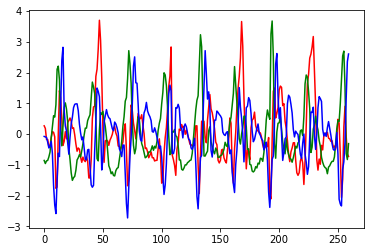

In [14]:
plot_series(X_train[0, :, :])

Can we tell between different people's data by eye?

Let's plot a few series for some different people - say, 5 series for 3 people.

![](three.png)

### The neural network

In [40]:
from keras.layers import Conv1D, MaxPooling1D, Flatten

In [45]:
# Initiate the model - we'll use a sequential model so we can add to it
model = Sequential()

# Start with a convolutional layer:
#  * filters: The number of "features" we want to learn; number of patterns to try to identify
#  * kernel_size: The "window" to consider, i.e. we look at a rolling window captuiring [kernel_size] time points at once
#  * strides: How many time steps to "roll forward" each time we move the window
#  * activation: The activation function to use; convolutional layers typically use REctified Linear Unit function
#  * input_shape: We're feeding in observations each of shape 260{time points}*3{directional acceleration features}
model.add(Conv1D(filters=40, kernel_size=40, strides=2, activation="relu", input_shape=(260, 3)))
print(model.output_shape)

model.add(MaxPooling1D(pool_size=2))
print(model.output_shape)

# Another convolutional layer: this one finds "meta-patterns" in the patterns the first layer picked up
model.add(Conv1D(filters=40, kernel_size=10, activation="relu"))
print(model.output_shape)

# If the net is too large and computation too slow, we can reduce the number of parameters with max pooling
# This layer would reduce the number of parameters by half by combining ("pooling") parameters
# i.e. parameters get paired up (by position) and the maximum one only is kept
model.add(MaxPooling1D(pool_size=2))
print(model.output_shape)

# We still have a 3-dimensional set of parameters - we need to make this 2-dimensional, so we "flatten"
# (Unstack all the leaves and lay them out next to each other)
model.add(Flatten())
print(model.output_shape)

# We need to finish with a couple of dense layers: one to detect relationships between the (flattened)
# convolutional neurons, and...
model.add(Dense(100, activation="sigmoid"))
print(model.output_shape)

# ... one to present the output as a one-hot vector.
# (We typically use softmax in the very final layer since it provides a "stronger" signal than sigmoid)
model.add(Dense(15, activation="softmax"))
print(model.output_shape)

(None, 111, 40)
(None, 55, 40)
(None, 46, 40)
(None, 23, 40)
(None, 920)
(None, 100)
(None, 15)


In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 111, 40)           4840      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 55, 40)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 46, 40)            16040     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 23, 40)            0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 920)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               92100     
_________________________________________________________________
dense_16 (Dense)             (None, 15)                1515      
Total para

In [47]:
# We have to compile the network before we can run it, defining:
# * Loss function to use (always categorical cross-entropy for multi-class logistic regression)
# * Optimizer to use
#   ("adam" = "ADAptive Movement estimation", but e.g. "sgd" = "Stochastic Gradient Descent" will work, just slower)
# * Metrics to report (NOT used for adjusting parameters - that's what the loss function is for!)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [48]:
# Fit it!
# * X_train and y_train are training data/labels
# * epochs: How many times to pass the training data through and update the network's parameters
# * batch_size: How many observations to include in each batch the optimizer sees
# * Also show us the accuracy for the cross-validation set
model.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_val, y_val))

Train on 4075 samples, validate on 1358 samples
Epoch 1/10
4075/4075 [==============================] - 5s 1ms/step - loss: 2.4143 - acc: 0.2270 - val_loss: 1.8369 - val_acc: 0.4934
Epoch 2/10
4075/4075 [==============================] - 3s 850us/step - loss: 1.2670 - acc: 0.6834 - val_loss: 0.9378 - val_acc: 0.7563
Epoch 3/10
4075/4075 [==============================] - 3s 853us/step - loss: 0.7233 - acc: 0.8213 - val_loss: 0.6626 - val_acc: 0.8343
Epoch 4/10
4075/4075 [==============================] - 4s 860us/step - loss: 0.5104 - acc: 0.8827 - val_loss: 0.5199 - val_acc: 0.8638
Epoch 5/10
4075/4075 [==============================] - 4s 865us/step - loss: 0.3721 - acc: 0.9249 - val_loss: 0.4186 - val_acc: 0.9013
Epoch 6/10
4075/4075 [==============================] - 4s 867us/step - loss: 0.2846 - acc: 0.9467 - val_loss: 0.3619 - val_acc: 0.9087
Epoch 7/10
4075/4075 [==============================] - 4s 867us/step - loss: 0.2200 - acc: 0.9656 - val_loss: 0.3199 - val_acc: 0.9242
Ep

At this point we could try to improve that cross-validation accuracy score, e.g. change network structure.

### Reporting

In [49]:
from sklearn.metrics import classification_report, confusion_matrix

In [52]:
y_pred = model.predict_classes(X_test)
print(classification_report(np.argmax(y_test, axis=1), y_pred))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

             precision    recall  f1-score   support

          0       0.98      0.97      0.98       105
          1       0.95      0.91      0.93        82
          2       0.90      0.81      0.85        75
          3       0.97      0.95      0.96       100
          4       0.97      0.84      0.90        75
          5       0.93      0.98      0.95       116
          6       0.90      0.86      0.88        73
          7       0.91      0.89      0.90        84
          8       0.95      0.98      0.96        83
          9       0.85      0.99      0.91        85
         10       0.96      1.00      0.98        95
         11       0.86      0.93      0.90        88
         12       0.99      1.00      0.99        93
         13       0.92      0.93      0.92       105
         14       0.97      0.88      0.92       100

avg / total       0.94      0.93      0.93      1359

[[102   0   1   0   0   0   0   0   0   0   1   0   0   1   0]
 [  0  75   0   0   0   0   1   0

---

## Visualising features

We can try to visualise the "features" of the time series which the convolutional layers of the net have learned to identify.

In [ ]:
# Get the values from each layer
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_dict

In [ ]:
# Plot the weights from a given layer
def plot_filter(layer, k):
    x = layer_dict[layer].get_weights()[0][:, :, k]
    plt.plot(x[:, 0], color="red")
    plt.plot(x[:, 1], color="green")
    plt.plot(x[:, 2], color="blue")

In [ ]:
plot_filter("conv1d_1", 9)

We can also see if there are any patterns in the autocorrelation plots which might suggest strong periodicity.

In [ ]:
def plot_filter_corr(layer, k):
    x = layer_dict[layer].get_weights()[0][:, :, k]
    t0 = np.correlate(x[:, 0], x[:, 0], mode="full")
    t1 = np.correlate(x[:, 1], x[:, 1], mode="full")
    t2 = np.correlate(x[:, 2], x[:, 2], mode="full")
    plt.plot(t0[int(len(t0)/2):], color="red")
    plt.plot(t1[int(len(t1)/2):], color="green")
    plt.plot(t2[int(len(t2)/2):], color="blue")

In [ ]:
plot_filter_corr("conv1d_1", 9)

Let's plot each filter with its autocorrelation plot.

In [ ]:
ax, fig = plt.subplots(ncols=2, nrows=10, figsize=(20, 40))

for k in range(10):
    plt.subplot(10, 2, 2*k + 1)
    plot_filter("conv1d_1", k)
    plt.subplot(10, 2, 2*k + 2)
    plot_filter_corr("conv1d_1", k)